# Chess classification

- using CNN architecture
- challenges : image dataset doesnt have format and ukuran yang seragam
- we use ImageDataGenerator to solve it

- we use transfer learning to increase accuration

1. Download and import datasets

In [ ]:
    !wget --no-check-certificate \
      https://github.com/dicodingacademy/assets/raw/main/ml_pengembangan_academy/Chessman-image-dataset.zip \
      -O /tmp/Chessman-image-dataset.zip

--2022-04-04 04:06:56--  https://github.com/dicodingacademy/assets/raw/main/ml_pengembangan_academy/Chessman-image-dataset.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dicodingacademy/assets/main/ml_pengembangan_academy/Chessman-image-dataset.zip [following]
--2022-04-04 04:06:56--  https://raw.githubusercontent.com/dicodingacademy/assets/main/ml_pengembangan_academy/Chessman-image-dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60684125 (58M) [application/zip]
Saving to: ‘/tmp/Chessman-image-dataset.zip’

/tmp/Chessman-image 100%[===================>]  57.87M   194MB/s    in 

2. extraxt zip file to directory /tmp

In [ ]:
    import os
    import zipfile

    local_zip = '/tmp/Chessman-image-dataset.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('/tmp')
    zip_ref.close()

In [77]:
    os.listdir('/tmp/Chessman-image-dataset/Chess')

['Knight', 'Bishop', 'Pawn', 'Queen', 'King', 'Rook']

In [78]:
    print('total pawn images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/Pawn')))
    print('total King images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/King')))
    print('total Knight images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/Knight')))

    print('total Bishop images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/Bishop')))
    print('total Rook images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/Rook')))
    print('total Queen images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/Queen')))

total pawn images : 107
total King images : 76
total Knight images : 106
total Bishop images : 87
total Rook images : 102
total Queen images : 78


-  Dari output dapat dilihat bahwa jumlah sampel pada tiap direktori berbeda. Perlu diperhatikan juga dataset ini berukuran sangat kecil sehingga performa dari model mungkin tidak akan terlalu baik. Kita akan mencoba menggunakan augmentasi gambar untuk mengatasi masalah ini.

4. Next, we apply image augmentation to our datasets

In [ ]:
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    train_dir = os.path.join('/tmp/Chessman-image-dataset/Chess')
    train_datagen = ImageDataGenerator(rescale=1./255,
        rotation_range=20,
        zoom_range=0.2,
        shear_range=0.2,
        fill_mode = 'nearest',
        validation_split=0.1) # set validation split

- our dataset only consist of 1 directory and doesnt split into directory training & testing.
- but calm down, with ``ImageDataGenerator`` we doesnt need susah payah to split directory manually. cukup dengan ``validation_split``.
- we only tell dataTraining and dataTesting by add ``subset`` parameter with values ``training`` and ``validation``

5. split to data training and testing

In [31]:
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=8,
        class_mode='categorical',
        subset='training') # set as training data
    validation_generator = train_datagen.flow_from_directory(
        train_dir, # same directory as training data
        target_size=(150, 150),
        batch_size=16,
        class_mode='categorical',
        subset='validation')

Found 499 images belonging to 6 classes.
Found 52 images belonging to 6 classes.


6. make model + implement transfer learning

- Nah, disini kita mulai mengimplementasikan transfer learning. Untuk model yang kita pilih sebagai model dasar transfer learning adalah ResNet152V2. 

- Model ResNet152V2 memiliki sebanyak 152 layer dan tersedia di library keras. Kita dapat memanfaatkan fitur-fitur yang telah dipelajari oleh model tersebut untuk dipakai model kita. 

- Untuk mengimplementasikan transfer learning sangatlah mudah seperti kode di bawah. Kita hanya perlu menambahkan 2 buah baris kode berbeda. Layer pertama pada model kita adalah model yang kita pakai untuk transfer learning. Kita cukup memanggil kelas ResNet152V2 dan mengisi parameter sebagai berikut:

  - Weight : ini adalah bobot atau parameter seperti yang telah dibahas pada kelas machine learning pemula. Untuk parameter weight kita mengisi nilai ‘imagenet’. Artinya kita ingin menggunakan model ResNet152V2 yang telah dilatih pada dataset imagenet. Imagenet adalah sebuah database raksasa yang berisi lebih dari 14 juta gambar.
  - Include_top : parameter ini bernilai boolean. Maksud dari parameter ini apabila kita ingin tetap memakai layer terakhir/layer prediksi dari model resnet. Kita isi false karena kita memakai model resnet untuk memprediksi dataset chessman bukan imagenet.
  - Input_tensor : sesuai namanya parameter ini menspesifikasikan ukuran dari input.

In [32]:
    import tensorflow as tf
    from tensorflow.keras.layers import Input
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.applications import ResNet152V2

    model = tf.keras.models.Sequential([
                                        
        ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),

        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')  
    ])
    model.layers[0].trainable = False

234561536/234545216 [==============================] - 2s 0us/step


- before model ready to train. it need several setting again. this add in compile stage

In [33]:
    model.compile(optimizer=tf.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

- start training model

In [35]:
    history = model.fit(train_generator,
                                  validation_data=validation_generator,
                                  epochs=50,
                                  verbose=2)

Epoch 1/50
63/63 - 144s - loss: 10.0613 - accuracy: 0.4389 - val_loss: 2.3057 - val_accuracy: 0.6154 - 144s/epoch - 2s/step
Epoch 2/50
63/63 - 132s - loss: 1.7788 - accuracy: 0.6673 - val_loss: 1.7571 - val_accuracy: 0.5769 - 132s/epoch - 2s/step
Epoch 3/50
63/63 - 131s - loss: 0.9966 - accuracy: 0.7575 - val_loss: 1.4760 - val_accuracy: 0.6923 - 131s/epoch - 2s/step
Epoch 4/50
63/63 - 130s - loss: 0.8904 - accuracy: 0.7936 - val_loss: 1.0561 - val_accuracy: 0.7692 - 130s/epoch - 2s/step
Epoch 5/50
63/63 - 133s - loss: 0.6281 - accuracy: 0.8657 - val_loss: 0.7233 - val_accuracy: 0.7500 - 133s/epoch - 2s/step
Epoch 6/50
63/63 - 129s - loss: 0.5156 - accuracy: 0.8417 - val_loss: 0.9294 - val_accuracy: 0.7500 - 129s/epoch - 2s/step
Epoch 7/50
63/63 - 130s - loss: 0.6241 - accuracy: 0.8477 - val_loss: 1.4291 - val_accuracy: 0.7308 - 130s/epoch - 2s/step
Epoch 8/50
63/63 - 130s - loss: 0.5824 - accuracy: 0.8677 - val_loss: 1.1428 - val_accuracy: 0.7500 - 130s/epoch - 2s/step
Epoch 9/50
63/6

- Tingkat akurasi menunjukkan hasil yang jauh lebih baik dibandingkan ketika melatih model sendiri dari awal. Akurasi dari model meningkat 40% menjadi 70 pada epoch terakhir. Hasil ini sangat luar biasa mengingat setiap kelas pada sampel kita sangat sedikit yaitu kurang dari 100 buah sampel.

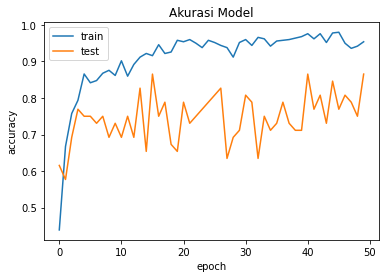

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

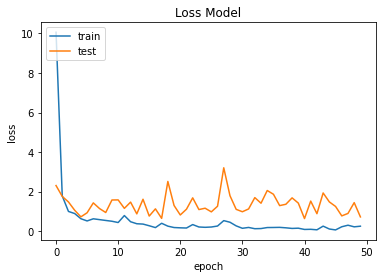

In [37]:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss Model')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Save and Load Trained Model

save model

- model yang telah disave dan tersimpan sementara di folder /tmp dapat dipindahkan ke google drive.

- cara memindahkannya yaitu dengan mengaktifkan mount drive lalu reload kemudian drag file model dari /temp -> /content/drive/MyDrive/..

- image [link](https://drive.google.com/file/d/1Fqn2OBSsSDID3yoozR7IRgSwv20jaFP1/view?usp=sharing)


In [38]:
import joblib

joblib.dump(model,"/tmp/modelClassification_img_5a.pkl")

INFO:tensorflow:Assets written to: ram://ebe66f0a-7280-482a-91b9-195ae4b2ba4a/assets


['/tmp/model.pkl']

Load model

- model dapat diload dari google drive melalui path  /content/drive/MyDrive/..


In [73]:
model_1 = joblib.load('/content/drive/MyDrive/model.pkl')

make predictions

In [65]:
# Parameters
input_size = (150,150) # Bisa kalian ganti

#define input shape
channel = (3,)
input_shape = input_size + channel

#define labels
labels = ['Bishop', 'KING', 'Knight', 'Pawn', 'Queen', 'ROOK']

def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

KING 0.6145868


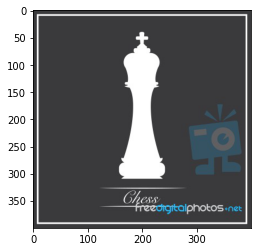

In [84]:
from PIL import Image 
 
# read image
im = Image.open('/tmp/Chessman-image-dataset/Chess/King/00000000.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model_1.predict(X)

imgplot = plt.imshow(im)

# print(y)
print( labels[np.argmax(y)], np.max(y) )



referensi predict code : https://medium.com/@hafizhan.aliady/membuat-klasifikasi-gambar-images-menggunakan-keras-tensorflow-tf-keras-dan-python-53f7ae953cea

- trained model result [link](https://drive.google.com/file/d/1jQulMtqamG0nWNpJR1T-ONqPZ4Q2OfsJ/view?usp=sharing) 